# Learning Spatiotemporal-Aware Representation for POI Recommendation

Base on paper [Learning Spatiotemporal-Aware Representation for POI Recommendation](https://arxiv.org/abs/1704.08853)

### The dataset
Dataset is an open dataset [the second dataset at this page](https://sites.google.com/site/yangdingqi/home/foursquare-dataset),This is a dataset containing user,poi(restaurant,gym,office .etc), spatio temporal data(a cool vocab, yeah!), come words description about the poi. I configured the txt file to any csv file with \t as separator.

The user & poi are in form of ID, user ids I guess, are reset to natural number for privacy reasons. We can mine users' habbit on location with time stamp for recommandation purpose. A task I tried before, but not to wonderful results.

### Difference from paper

* I ran on my macbook air, so I tune down the capacity into a moderate scale:
    * batchsize 1024 (4800)
    * epochs 100 (1000)
    * I only used the New York data on foursqaure
* when slicing the geo location to slots, I set 2 embedings represents latitude & longitude and cut them in to 100 slots for each dimenstion, the paper only has 1 embeding for geo, and they use administrative area for sloting, which is a more scientific way to do it. And my procrastination suggest me not doing this for now.

* I use a projection matrix $\large M_{tl}$ as paper suggested, and also experimented:
    * a model without $\large M_{tl}$
    * a 2 layer neural network as $\large M_{tl}$, will we make the model fit better if this link is deeper? (No it won't)

* I use Adam optimizer instead of SGD, so I didn't overthought the choice of learning rate. 
* Changed summed error to average, hence the score & loss will make much more meaning.

### Things to try

1. Use geo grid/ administrative area as embedding slots
2. Figure out the better way to measure the quality of recommendation, compare across other models
3. Make embedding dimension for weekday/weekend/hoilday, season

In [4]:
import pandas as pd
import numpy as np

In [23]:
DATA = u"/data/foursquare/dataset_TSMC2014_NYC.txt"
TIME_SLOT  = 24 # in minutes

Let's check the field names in read me file

In [6]:
open("/data/foursquare/dataset_TSMC2014_readme.txt").read().split("\n")[:12]

['This dataset includes long-term (about 10 months) check-in data in New York city and Tokyo collected from Foursquare from 12 April 2012 to 16 February 2013.',
 'It contains two files in tsv format. Each file contains 8 columns, which are:',
 '',
 '1. User ID (anonymized)',
 '2. Venue ID (Foursquare)',
 '3. Venue category ID (Foursquare)',
 '4. Venue category name (Fousquare)',
 '5. Latitude',
 '6. Longitude',
 '7. Timezone offset in minutes (The offset in minutes between when this check-in occurred and the same time in UTC)',
 '8. UTC time',
 '']

Open the csv data into dataframe

In [24]:
cols = ["uid","poi_id","poi_cat","poi_catname","lati","longi","tz_offset","utc"]
df = pd.read_csv(DATA,names=cols,sep="\t",encoding = "iso-8859-1")

Look at some sample of data

In [5]:
df.sample(10)

,uid,poi_id,poi_cat,poi_catname,lati,longi,tz_offset,utc
28100,51,4ba5040cf964a520c6d038e3,4bf58dd8d48988d120941735,Bar,40.722343,-73.987838,-240,Sat Apr 21 03:09:29 +0000 2012
56837,906,4a896d11f964a520020820e3,4bf58dd8d48988d196941735,Medical Center,40.646717,-74.021115,-240,Wed May 09 10:32:16 +0000 2012
89943,380,4ce47104ae896dcbee855038,4bf58dd8d48988d103941735,Home (private),40.595556,-73.800734,-240,Thu May 31 14:06:22 +0000 2012
121050,341,4a9c60eef964a520ff3620e3,4bf58dd8d48988d103951735,Clothing Store,40.750248,-73.989916,-240,Wed Jul 04 16:11:30 +0000 2012
205569,799,4c7d8a41d461a1438b857df5,4bf58dd8d48988d176941735,Gym / Fitness Center,40.760920,-73.930072,-300,Thu Jan 03 00:03:01 +0000 2013
110971,267,4eeaa4ed77c8730d38061384,4bf58dd8d48988d129951735,Train Station,40.858468,-73.855928,-240,Sun Jun 17 01:29:04 +0000 2012
42578,974,4ea37694b6347b99683dcb09,4bf58dd8d48988d1e4941735,Campground,40.671720,-73.806603,-240,Sun Apr 29 05:23:50 +0000 2012
173255,589,4b1be8cef964a520defe23e3,4bf58dd8d48988d1e0931735,Coffee Shop,40.972154,-73.960905,-300,Thu Nov 08 11:16:02 +0000 2012
103183,12,4bb92a9453649c74dacb47fb,4bf58dd8d48988d156941735,Malaysian Restaurant,40.715751,-73.996619,-240,Sun Jun 10 00:29:05 +0000 2012
55640,631,4ba2acb7f964a520ee0e38e3,4bf58dd8d48988d151941735,Taco Place,40.897506,-74.103455,-240,Tue May 08 18:49:22 +0000 2012


### Slice time into slot

In [26]:
SLOT_LEN = int(60*24/TIME_SLOT)
def day_range(x):
    return -1*(x//SLOT_LEN)*SLOT_LEN+x

df = df.sample(frac=1)

df["minute"] = df.utc.apply(lambda x:int(x[14:16]))
df["second"] = df.utc.apply(lambda x:int(x[17:20]))
df["hour"] = df.utc.apply(lambda x:int(x[11:13]))
df["temporal"] = df.minute+df.hour*60+df.tz_offset
df["t_slot"] = df["temporal"].apply(lambda x:int(x/TIME_SLOT)).apply(day_range) # 24 minutes a slot
df.sample(3)

,uid,poi_id,poi_cat,poi_catname,lati,longi,tz_offset,utc,minute,second,hour,temporal,t_slot
33129,384,4cfe59617945224ba23895e7,4bf58dd8d48988d128941735,Office,40.693343,-73.985824,-240,Mon Apr 23 22:14:07 +0000 2012,14,7,22,1094,45
221321,988,50aeffa8e4b099c5499dbeea,4d954b06a243a5684965b473,Residential Building (Apartment / Condo),40.858729,-73.868765,-300,Sun Feb 03 00:18:19 +0000 2013,18,19,0,-282,49
63980,527,4e8a3b0e29c2b5bbaf1628cc,4bf58dd8d48988d130951735,Taxi,40.793377,-73.957069,-240,Sun May 13 02:42:07 +0000 2012,42,7,2,-78,57


In [27]:
df["t_slot"].describe()

count    227428.000000
mean         33.769334
std          15.038828
min           0.000000
25%          23.000000
50%          35.000000
75%          46.000000
max          59.000000
Name: t_slot, dtype: float64

### Slice Location into slot

In [28]:
for dim in ["lati","longi"]:
    grid_min = df[dim].min()
    grid_len = (df[dim].max()-grid_min)/100
    
    df[dim+"_slot"] = df[dim].apply(lambda x:int((x-grid_min)//grid_len))

In [29]:
df.lati_slot.value_counts()[:5]


47    12463
43    11282
46    11093
44     9787
48     9558
Name: lati_slot, dtype: int64

In [30]:
df.longi_slot.value_counts()[:5]

48    26359
49    18652
47    17899
50    13476
46    11482
Name: longi_slot, dtype: int64

In [31]:
import torch
from torch import nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [32]:
df.describe()

,uid,lati,longi,tz_offset,minute,second,hour,temporal,t_slot,lati_slot,longi_slot
count,227428.000000,227428.000000,227428.000000,227428.000000,227428.000000,227428.000000,227428.000000,227428.000000,227428.000000,227428.000000,227428.000000
mean,535.304817,40.754045,-73.974556,-253.392019,29.363047,29.362515,13.215215,568.883950,33.769334,45.943375,50.308295
std,305.398774,0.072458,0.086209,43.234750,17.347373,17.325000,7.284155,439.739211,15.038828,16.567249,14.600046
min,1.000000,40.550852,-74.274766,-420.000000,0.000000,0.000000,0.000000,-306.000000,0.000000,0.000000,0.000000
25%,287.000000,40.718330,-74.000633,-240.000000,14.000000,14.000000,8.000000,225.000000,23.000000,38.000000,46.000000
50%,523.000000,40.747745,-73.983479,-240.000000,29.000000,29.000000,14.000000,645.000000,35.000000,45.000000,49.000000
75%,793.000000,40.778374,-73.945709,-240.000000,44.000000,44.000000,19.000000,929.000000,46.000000,52.000000,55.000000
max,1083.000000,40.988332,-73.683825,660.000000,59.000000,59.000000,23.000000,2002.000000,59.000000,99.000000,99.000000


###  Indexing the poi

In [33]:
IDX2POI=dict((idx,pid) for idx,pid in enumerate(set(df.poi_id)))
POI2IDX=dict((pid,idx) for idx,pid in enumerate(set(df.poi_id)))
len(IDX2POI)

38333

In [34]:
df["p_idx"]=df.poi_id.apply(lambda x:POI2IDX[x])

### From DataFrame to Numpy array

#### and create the corrupted data

In [35]:
from collections import Counter
def df2array(df):
    """Transfer dataframe to numpy array for training"""
    users = np.array(list(df.uid)).reshape(-1,1)
    poi = np.array(list(df.p_idx)).reshape(-1,1)
    lati = np.array(list(df.lati_slot)).reshape(-1,1)
    longi = np.array(list(df.longi_slot)).reshape(-1,1)
    time = np.array(list(df.t_slot)).reshape(-1,1)

    lt = np.concatenate([lati,longi,time],axis=-1)
    #Corrupted data
    cor_u=users.copy()
    cor_p=poi.copy()
    
    user_popu = len(set(users.reshape(-1))) # pupulation of user
    poi_popu = len(set(poi.reshape(-1))) # population of poi
    
    hpt = np.average(list(v for k,v in Counter(users.reshape(-1)).items()))
    tph = np.average(list(v for k,v in Counter(poi.reshape(-1)).items()))
    print("Head/Tail",hpt,"Tail/Head",tph)
    
    head_cor = tph/(tph+hpt)
    
    cor_slice = (np.random.rand(len(users))<head_cor)
    print(head_cor)
    
    u_s_part = cor_u[cor_slice].copy() # shuffle part of user
    p_s_part = cor_p[~cor_slice].copy() # shuffle part of poi
    
    np.random.shuffle(u_s_part)
    np.random.shuffle(p_s_part)
    
    cor_u[cor_slice] = u_s_part
    cor_p[~cor_slice] = p_s_part

    return users,poi,lati,longi,time,lt,cor_u,cor_p

# Sampling slice
choose = (np.random.rand(len(df))>.9)

users,poi,lati,longi,time,lt,cor_u,cor_p = df2array(df)
trn_users,trn_poi,trn_lati,trn_longi,trn_time,trn_lt,trn_cor_u,trn_cor_p = df2array(df[~choose])
val_users,val_poi,val_lati,val_longi,val_time,val_lt,val_cor_u,val_cor_p = df2array(df[choose])


Head/Tail 209.99815327793166 Tail/Head 5.932955938747294
0.027476151816521212
Head/Tail 189.1163434903047 Tail/Head 5.591400491400491
0.028716888075729856
Head/Tail 20.881809787626963 Tail/Head 2.024438277683287
0.08837930471682715


In [16]:
np.concatenate([users,cor_u,poi,cor_p],axis=-1)[:20]

array([[ 1051,  1051, 28600,  5326],
       [  156,   818, 22176, 22176],
       [  521,   521, 27070, 18620],
       [  488,   488, 12053, 13693],
       [   80,    80, 19006, 29081],
       [  354,   975, 15121, 15121],
       [ 1019,  1019, 34191, 29311],
       [  623,   623, 11341,   595],
       [  528,   528, 26973,  1328],
       [  792,   792,  6571, 34868],
       [  461,   461,  3671, 21684],
       [  350,   350,  9998, 36310],
       [  128,   128, 26755,  9688],
       [  972,   972, 17822, 28612],
       [   21,    21,  9232, 23259],
       [  191,   594, 22621, 22621],
       [  757,   757, 29644, 33133],
       [   80,    80, 29748, 16844],
       [  689,   689, 36120, 22932],
       [ 1079,  1079, 29219,  9199]])

In [17]:
user_popu = len(set(users.reshape(-1))) # pupulation of user
poi_popu = len(set(poi.reshape(-1))) # population of poi
len(users),len(trn_users),len(val_users),user_popu,poi_popu

(227428, 204577, 22851, 1083, 38333)

### Data Generator

The data generator will spit out user, poi, spatiotemporal data, coruppted user & coruppted poi

In [18]:
class sta_dt(Dataset):
    def __init__(self,**kwargs):
        super(sta_dt,self).__init__()
        for k,v in kwargs.items():
            setattr(self,k,v)
    
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self,idx):
        """
        it will spit out the following in a tuple:
        1. user idx for user embedding
        2. poi idx for poi embedding
        3. Latitude, longitude and time idices for 3 embedings
        4. corrupted user idx for user embedding
        5. corrupted poi idx for poi embedding
        """
        return self.users[idx],self.poi[idx],self.lt[idx],self.cor_u[idx],self.cor_p[idx]

train_dataset = sta_dt(users=trn_users,
           poi=trn_poi,
            lt=trn_lt,
            cor_u=trn_cor_u,
            cor_p=trn_cor_p,
            )

valid_dataset = sta_dt(users = val_users,
           poi = val_poi,
            lt = val_lt,
            cor_u = val_cor_u,
            cor_p = val_cor_p,
            )

train_load = DataLoader(train_dataset,batch_size=1024,shuffle = True)
valid_load = DataLoader(valid_dataset,batch_size=1024,shuffle = True)
gen = iter(train_load)
for var in next(gen):
    print(var.size())

torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 3])
torch.Size([1024, 1])
torch.Size([1024, 1])


### STA Model

Forward Computation of score:

$\large \vec u_{tl} = \vec u M_{tl}; \vec v_{tl} = \vec v M_{tl}$

$\large M_{tl}$ is the projection matrix

$\large S_{tl}(u,v)=||\vec u_{tl} +\vec tl - \vec v_{tl}||_{2}^{2}$

$\large s.t.||\vec u||_{2}\leq1,||\vec v||_{2}\leq1,||\vec tl||_{2}\leq1$

$\large ||\vec u_{tl}||_{2}\leq1,||\vec v_{tl}||_{2}\leq1$

In [19]:
from tqdm import trange
from torch.optim import SGD,Adam
from torch.autograd import Variable
from torch.nn import functional as F

As I've experimented, replacing Mtl to nn doesn't help converge

In [20]:
class Mtl(nn.Module):
    def __init__(self,in_d,out_m):
        """
        d is the dim size of tl embedding
        m is the dim size of u,v embedding
        """
        super(Mtl,self).__init__()
        self.in_d = in_d
        self.out_m = out_m
        
        self.fc1 = nn.Linear(self.in_d,self.out_m,bias=False)
        
    def forward(self,x):
        return self.fc1(x)
    
class Mtl_no_trans(nn.Module):
    def __init__(self):
        """
        No transformation at all
        """
        super(Mtl_no_trans,self).__init__()
        
    def forward(self,x):
        return x
    
class Mtl_nn(nn.Module):
    def __init__(self,in_d,out_m,hidden=128,last_act=None):
        """
        d is the dim size of tl embedding
        m is the dim size of u,v embedding
        """
        super(Mtl_nn,self).__init__()
        self.in_d = in_d
        self.out_m = out_m
        self.hidden = hidden
        self.last_act=last_act
        
        self.fc1 = nn.Linear(self.in_d,self.hidden,bias=True)
        self.bn = nn.BatchNorm1d(self.hidden)
        self.fc2 = nn.Linear(self.hidden,self.out_m,bias=True)
        self.dropout = nn.Dropout(.5)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.bn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        if self.last_act:
            x = self.last_act(x)
        return x

Objective funtion:

$\huge L=\Sigma_{\normalsize (u,tl,v) \in T}\Sigma_{\normalsize (u',tl,v') \in T'}\large max(0,S_{tl}(u,v)+\gamma-S_{tl}(u',v'))$

The paper suggest $\gamma = 2$

Adjusted objective funtion:

$\huge L=\Sigma_{\normalsize (u,tl,v) \in T}\Sigma_{\normalsize (u',tl,v') \in T'}\large max(0,\lambda S_{tl}(u,v)+\gamma-S_{tl}(u',v'))$

$\lambda = 1.5 $

In [21]:
class STA(nn.Module):
    def __init__(self,**kwargs):
        super(STA,self).__init__()
        for k,v in kwargs.items():
            # print(k,v)
            setattr(self,k,v)
        self.ebd_u = nn.Embedding(self.users_len,100,padding_idx=None,norm_type=2,max_norm=1)
        self.ebd_p = nn.Embedding(self.poi_len,100,padding_idx=None,norm_type=2,max_norm=1)
        self.ebd_t = nn.Embedding(self.t_len,60,padding_idx=None,norm_type=2,max_norm=1)
        self.ebd_lt = nn.Embedding(self.lati_len,30,padding_idx=None,norm_type=2,max_norm=1)
        self.ebd_lg = nn.Embedding(self.longi_len,30,padding_idx=None,norm_type=2,max_norm=1)
        
    def forward(self,u,p,spa_tem):
        lt = spa_tem[...,0]
        lg = spa_tem[...,1]
        time = spa_tem[...,2]
        
        u_vec = self.Mtl(self.ebd_u(u.view(-1)))
        p_vec = self.Mtl(self.ebd_p(p.view(-1)))
        
        t_vec = self.ebd_t(time)
        lt_vec = self.ebd_lt(lt)
        lg_vec = self.ebd_lt(lg)
        # spatiotemporal
        st = torch.cat([t_vec,lt_vec,lg_vec],dim=-1) 
#         score = torch.sqrt(torch.pow(u_vec+st-p_vec,2))
        score = F.pairwise_distance(u_vec+st,p_vec,p=2)

        return score

### Train Step

In [22]:
def action(*args,**kwargs):
    users,poi,lt,cor_user,cor_poi = args[0]
    users,poi,lt,cor_user,cor_poi = Variable(users),Variable(poi),Variable(lt),Variable(cor_user),Variable(cor_poi)
        # Using gpu
    if CUDA:
        users,poi,lt,cor_user,cor_poi = users.cuda(),poi.cuda(),lt.cuda(),cor_user.cuda(),cor_poi.cuda()
    #
    optimizer.zero_grad()
    
    # Score and Corrupted score from same model
    score = sta_(users,poi,lt)
    score_corrupt = sta_(cor_user,cor_poi,lt)
    # Objective function
    loss = torch.clamp(score+GAMMA-score_corrupt,0,None).mean()
    
    # Back propogate & optiize
    loss.backward()   
    optimizer.step()
    return {"score":score.mean().data[0],
            "score_corrupt":score_corrupt.mean().data[0],
            "loss":loss.data[0]
           }

def val_action(*args,**kwargs):
    users,poi,lt,cor_user,cor_poi = args[0]
    users,poi,lt,cor_user,cor_poi = Variable(users),Variable(poi),Variable(lt),Variable(cor_user),Variable(cor_poi)
        # Using gpu
    if CUDA:
        users,poi,lt,cor_user,cor_poi = users.cuda(),poi.cuda(),lt.cuda(),cor_user.cuda(),cor_poi.cuda()

    score = sta_(users,poi,lt)
    score_corrupt = sta_(cor_user,cor_poi,lt)
    
    # Objective function
    loss = torch.clamp(score+GAMMA-score_corrupt,0,None).mean()
    
    return {"score":score.mean().data[0],
            "score_corrupt":score_corrupt.mean().data[0],
            "loss":loss.data[0],
           }

## Training 1, Mtl as projection matrix

In [23]:
Mtl = Mtl(100,120)
sta_ = STA(users_len=int(np.unique(users)[-1]+1),
           poi_len=int(np.unique(poi)[-1]+1),
           lati_len=int(np.unique(lati)[-1]+1),
           longi_len=int(np.unique(longi)[-1]+1),
           t_len=int(np.unique(time)[-1]+1),
           Mtl=Mtl,
          )

In [24]:
CUDA = torch.cuda.is_available()
if CUDA:
    sta_.cuda()
optimizer =Adam(sta_.parameters())

In [25]:
from p3self.matchbox import Trainer

trainer=Trainer(train_dataset,valid_dataset,batch_size =1024,print_on=20)

In [26]:
trainer.action = action
trainer.val_action = val_action

In [27]:
GAMMA=2
trn_track,val_track = trainer.train(100)

⭐[ep_0_i_199]	loss	1.341✨	score	1.725✨	score_corrupt	2.387: 100%|██████████| 200/200 [00:23<00:00,  8.47it/s]
😎[val_ep_0_i_22]	loss	1.255😂	score	1.722😂	score_corrupt	2.475: 100%|██████████| 23/23 [00:00<00:00, 24.03it/s]
⭐[ep_1_i_199]	loss	0.539✨	score	2.010✨	score_corrupt	3.999: 100%|██████████| 200/200 [00:25<00:00,  7.82it/s]
😎[val_ep_1_i_22]	loss	0.640😂	score	2.100😂	score_corrupt	3.948: 100%|██████████| 23/23 [00:00<00:00, 24.53it/s]
⭐[ep_2_i_199]	loss	0.311✨	score	2.315✨	score_corrupt	4.931: 100%|██████████| 200/200 [00:25<00:00,  7.94it/s]
😎[val_ep_2_i_22]	loss	0.527😂	score	2.484😂	score_corrupt	4.774: 100%|██████████| 23/23 [00:01<00:00, 18.98it/s]
⭐[ep_3_i_199]	loss	0.198✨	score	2.631✨	score_corrupt	5.640: 100%|██████████| 200/200 [00:24<00:00,  8.26it/s]
😎[val_ep_3_i_22]	loss	0.487😂	score	2.852😂	score_corrupt	5.420: 100%|██████████| 23/23 [00:00<00:00, 24.15it/s]
⭐[ep_4_i_199]	loss	0.138✨	score	2.936✨	score_corrupt	6.227: 100%|██████████| 200/200 [00:26<00:00,  7.43it/s]
😎[val_

😎[val_ep_71_i_22]	loss	0.548😂	score	12.173😂	score_corrupt	19.811: 100%|██████████| 23/23 [00:00<00:00, 26.22it/s]
⭐[ep_72_i_199]	loss	0.002✨	score	11.423✨	score_corrupt	20.923: 100%|██████████| 200/200 [01:14<00:00,  2.68it/s]
😎[val_ep_72_i_22]	loss	0.554😂	score	12.230😂	score_corrupt	19.902: 100%|██████████| 23/23 [00:00<00:00, 27.02it/s]
⭐[ep_73_i_199]	loss	0.003✨	score	11.492✨	score_corrupt	21.027: 100%|██████████| 200/200 [01:10<00:00,  2.82it/s]
😎[val_ep_73_i_22]	loss	0.553😂	score	12.300😂	score_corrupt	19.998: 100%|██████████| 23/23 [00:00<00:00, 26.73it/s]
⭐[ep_74_i_199]	loss	0.003✨	score	11.580✨	score_corrupt	21.177: 100%|██████████| 200/200 [01:08<00:00,  2.91it/s]
😎[val_ep_74_i_22]	loss	0.559😂	score	12.399😂	score_corrupt	20.149: 100%|██████████| 23/23 [00:00<00:00, 28.00it/s]
⭐[ep_75_i_199]	loss	0.003✨	score	11.657✨	score_corrupt	21.292: 100%|██████████| 200/200 [01:07<00:00,  2.95it/s]
😎[val_ep_75_i_22]	loss	0.558😂	score	12.474😂	score_corrupt	20.245: 100%|██████████| 23/23 [00

### Save results

In [29]:
def todataframe(dict_):
    tracks=[]
    for i in range(len(dict_)):
        tracks+=dict_[i]

    return pd.DataFrame(tracks)
todataframe(trainer.track).to_csv("poi_track.0.0.5.csv")
todataframe(trainer.val_track).to_csv("poi_val_track.0.0.5.csv")

In [30]:
torch.save(sta_.state_dict(),"sta.0.0.5.pkl")

In [46]:
track_df0=pd.read_csv("/data/track/poi_track._new_cor.csv")
val_df0=pd.read_csv("/data/track/poi_val_track._new_cor.csv")
track_df=pd.read_csv("/data/track/poi_track.gamma2.csv")
val_df=pd.read_csv("/data/track/poi_val_track.gamma2.csv")

### Visualization

In [47]:
from matplotlib import pyplot as plt
%matplotlib inline

#### Score & Corrupt Score on train data

The orange line is the corrupt score

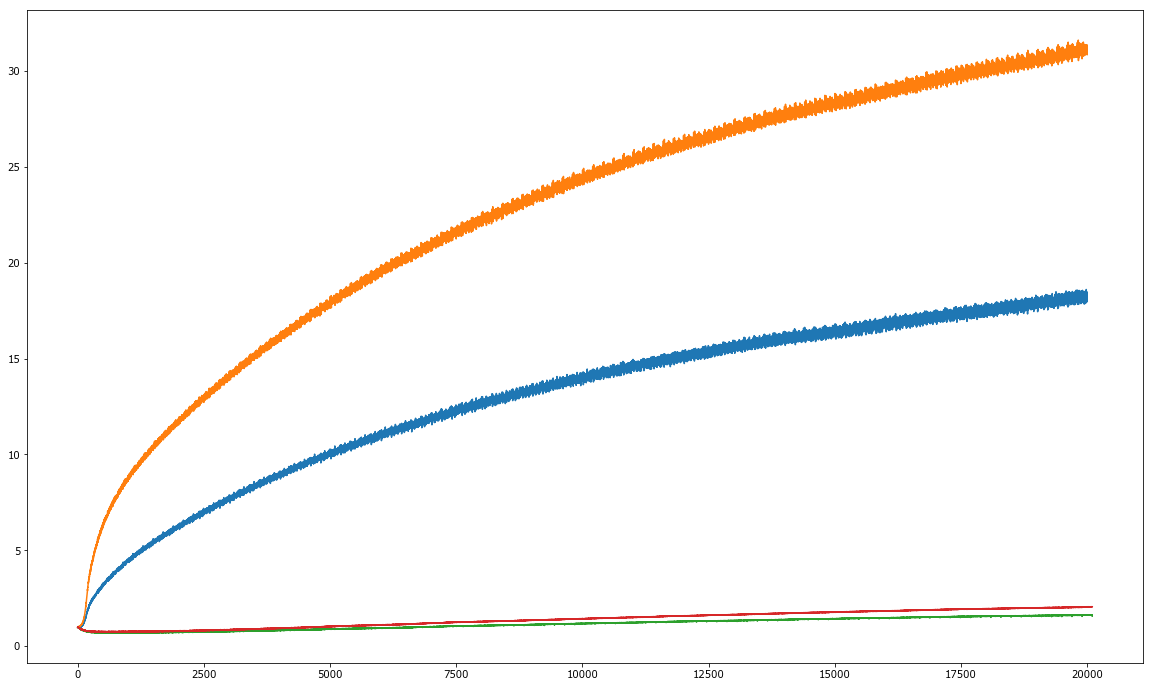

In [48]:
plt.figure(figsize=(20,12))
plt.plot(pd.concat([track_df0[["score","score_corrupt"]],
                    track_df[["score","score_corrupt"]]],axis=1))

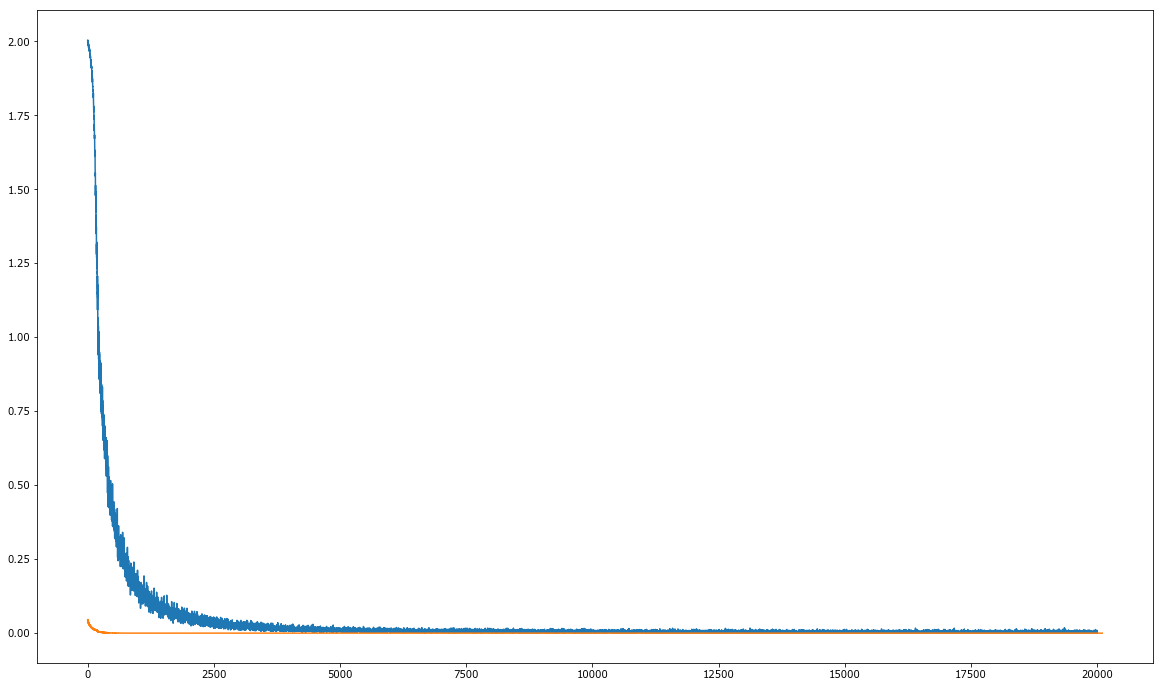

In [49]:
plt.figure(figsize=(20,12))
plt.plot(pd.concat([track_df0["loss"],
                    track_df["loss"]],axis=1))

#### Score & Corrupt Score on validation data

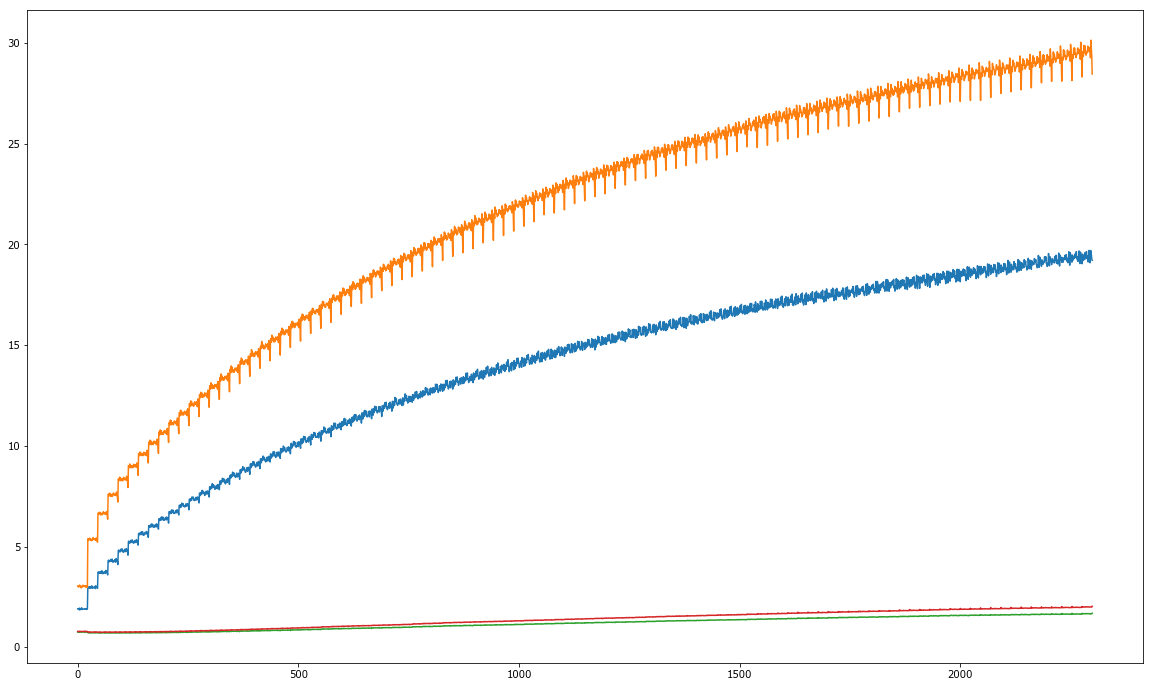

In [50]:
plt.figure(figsize=(20,12))
plt.plot(pd.concat([val_df0[["score","score_corrupt"]],
                    val_df[["score","score_corrupt"]]],axis=1))

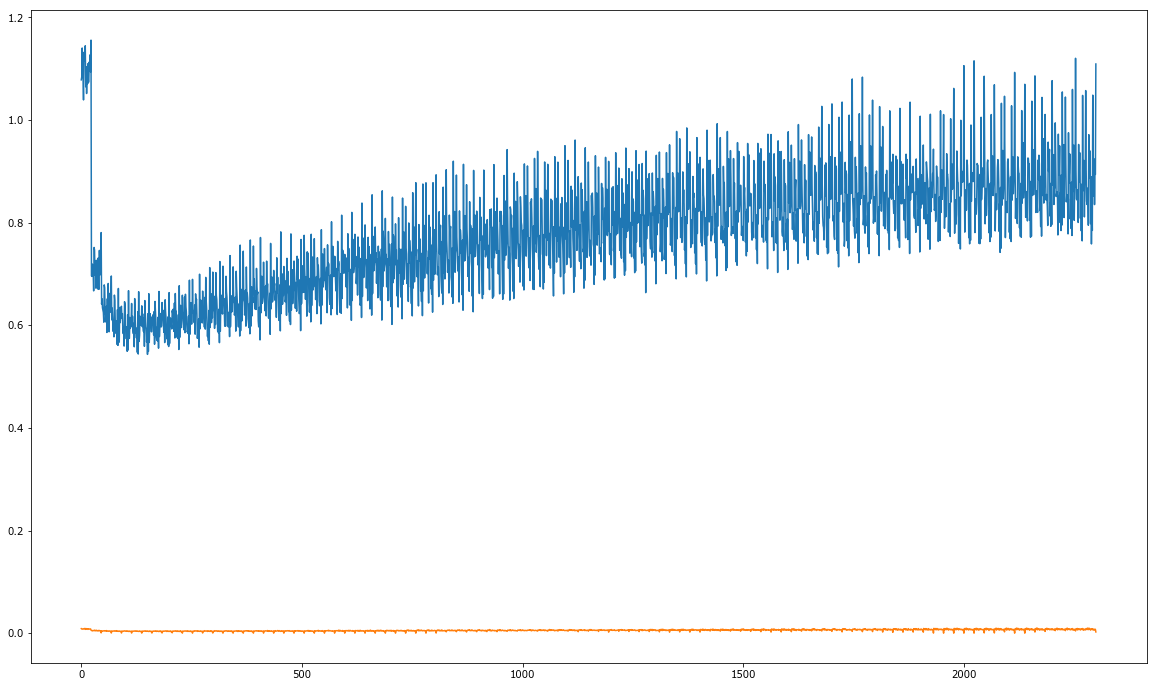

In [51]:
plt.figure(figsize=(20,12))
plt.plot(pd.concat([val_df0["loss"],
                    val_df["loss"]],axis=1))

#### Without Projection Matrix

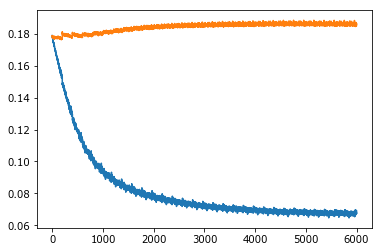

In [31]:
track_df=pd.read_csv("poi_track.0.0.1.csv")
val_df=pd.read_csv("poi_val_track.0.0.1.csv")
plt.plot(track_df[["score","score_corrupt"]])

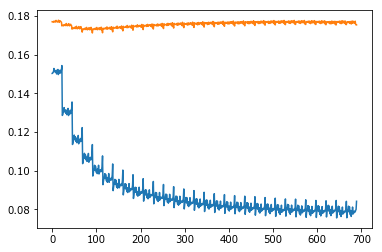

In [32]:
plt.plot(val_df[["score","score_corrupt"]])

In [35]:
from sklearn.decomposition import PCA

In [36]:
pca = PCA(2)

sta_.load_state_dict(torch.load("sta.0.0.5.pkl"))

poi_ebd_arr=sta_.ebd_p.weight.data.numpy()

poi_map = pca.fit_transform(poi_ebd_arr[:,:])

poi_map.shape

(38333, 2)

In [37]:
df_p_px = pd.DataFrame(poi_map[df["p_idx"]],columns=["mapx","mapy"])

In [38]:
df_p_px= pd.concat([df,df_p_px],axis=1)

In [39]:
sample_df = df_p_px[["poi_catname","lati","longi","mapx","mapy"]].sample(200).reset_index()

In [40]:
sample_df.head()

,index,poi_catname,lati,longi,mapx,mapy
0,41372,Salon / Barbershop,40.763240,-73.928230,0.090446,0.343386
1,178087,Drugstore / Pharmacy,40.685237,-73.980664,-0.159852,-0.363533
2,198976,College Academic Building,40.951965,-74.090252,-0.424469,-0.261093
3,148534,Deli / Bodega,40.865550,-73.857211,0.264228,0.176172
4,201762,Bagel Shop,40.736440,-73.997342,-0.586896,-0.364327


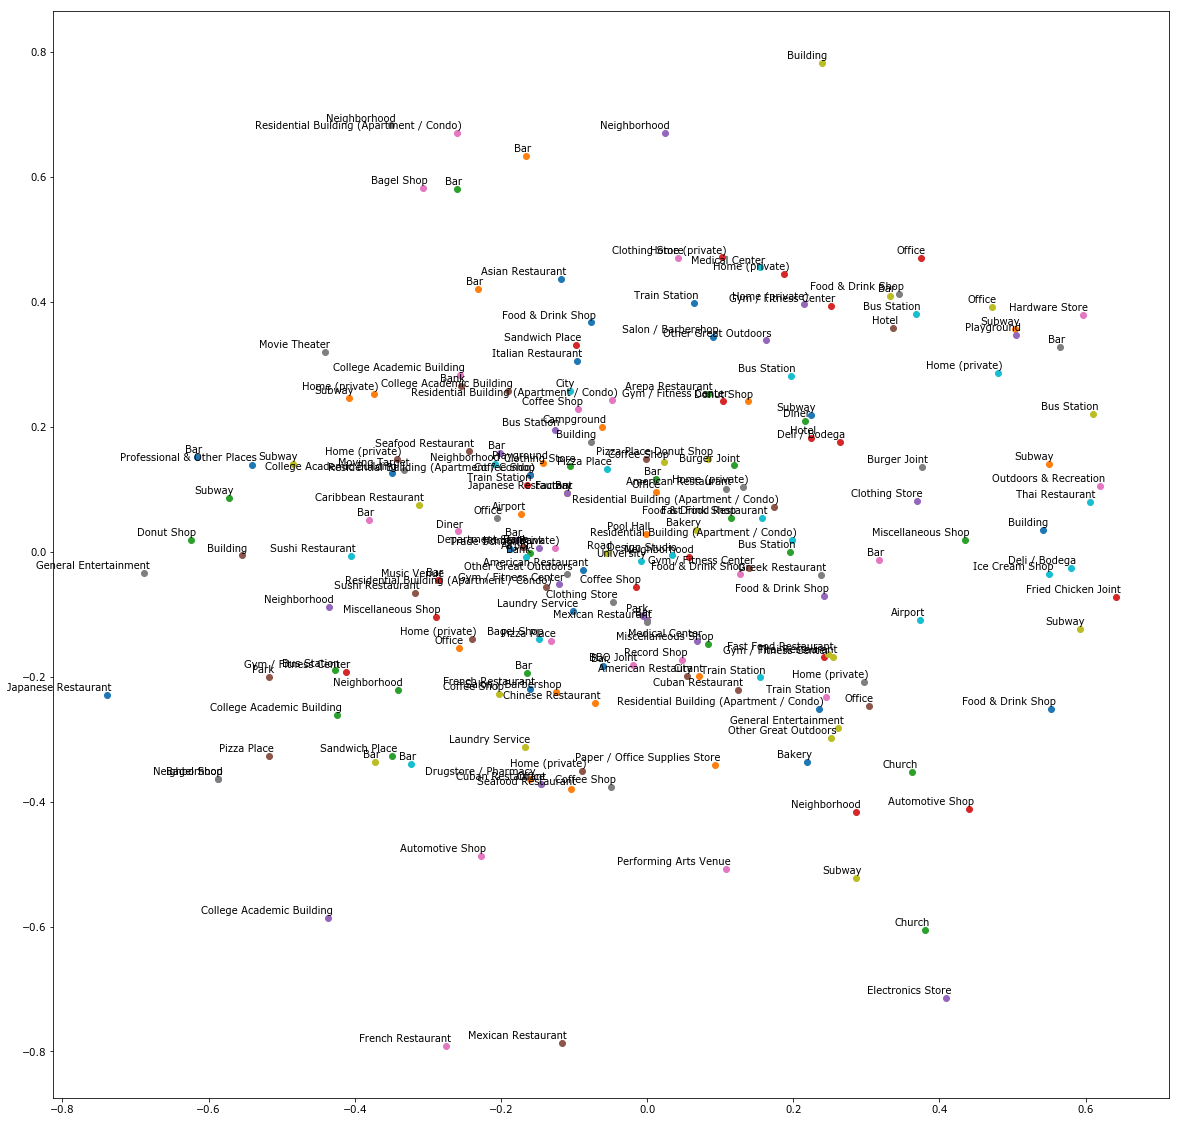

In [41]:

plt.figure(figsize=(20,20))
for i in range(len(sample_df)):
    if sample_df.loc[i,"poi_catname"] !=0:
        plt.scatter(sample_df.loc[i,"mapx"],sample_df.loc[i,"mapy"])
        plt.annotate(sample_df.loc[i,"poi_catname"],
                     xy=(sample_df.loc[i,"mapx"],sample_df.loc[i,"mapy"]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

### Training2: Mtl Deeper with Hidden Layer

In [21]:
Mtl_nn = Mtl_nn(100,120,last_act=None)
sta_ = STA(users_len=int(np.unique(users)[-1]+1),
           poi_len=int(np.unique(poi)[-1]+1),
           lati_len=int(np.unique(lati)[-1]+1),
           longi_len=int(np.unique(longi)[-1]+1),
           t_len=int(np.unique(time)[-1]+1),
           Mtl=Mtl_nn,
          )

In [22]:
CUDA = torch.cuda.is_available()
if CUDA:
    sta_.cuda()
optimizer =Adam(sta_.parameters())

In [23]:
from p3self.matchbox import Trainer
trainer_nn=Trainer(train_dataset,valid_dataset,batch_size =1024,print_on=20)

trainer_nn.action = action
trainer_nn.val_action = val_action

GAMMA=2
trn_track,val_track = trainer_nn.train(30)

⭐[ep_0_i_199]	loss	1.871✨	score	6.553✨	score_corrupt	6.710: 100%|██████████| 200/200 [00:41<00:00,  4.82it/s]
😎[val_ep_0_i_22]	loss	1.852😂	score	6.562😂	score_corrupt	6.743: 100%|██████████| 23/23 [00:01<00:00, 11.93it/s]
⭐[ep_1_i_199]	loss	1.740✨	score	6.799✨	score_corrupt	7.142: 100%|██████████| 200/200 [00:42<00:00,  4.66it/s]
😎[val_ep_1_i_22]	loss	1.732😂	score	6.804😂	score_corrupt	7.155: 100%|██████████| 23/23 [00:02<00:00, 10.80it/s]
⭐[ep_2_i_199]	loss	1.591✨	score	6.981✨	score_corrupt	7.553: 100%|██████████| 200/200 [00:43<00:00,  4.56it/s]
😎[val_ep_2_i_22]	loss	1.608😂	score	7.005😂	score_corrupt	7.561: 100%|██████████| 23/23 [00:01<00:00, 11.70it/s]
⭐[ep_3_i_199]	loss	1.467✨	score	7.075✨	score_corrupt	7.865: 100%|██████████| 200/200 [00:42<00:00,  4.69it/s]
😎[val_ep_3_i_22]	loss	1.500😂	score	7.107😂	score_corrupt	7.875: 100%|██████████| 23/23 [00:01<00:00, 11.68it/s]
⭐[ep_4_i_199]	loss	1.346✨	score	7.105✨	score_corrupt	8.130: 100%|██████████| 200/200 [00:41<00:00,  4.79it/s]
😎[val_

In [25]:
todataframe(trainer_nn.track).to_csv("poi_track_dl.0.0.3.csv")
todataframe(trainer_nn.val_track).to_csv("poi_val_track_dl.0.0.3.csv")
torch.save(sta_.state_dict(),"sta_dl.0.0.3.pkl")

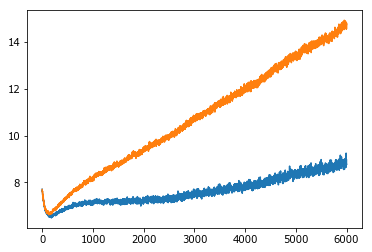

In [69]:
track_df=pd.read_csv("poi_track_dl.0.0.3.csv")
val_df=pd.read_csv("poi_val_track_dl.0.0.3.csv")
plt.plot(track_df[["score","score_corrupt"]])

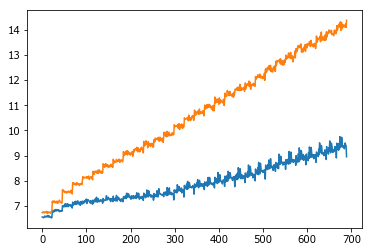

In [70]:
plt.plot(val_df[["score","score_corrupt"]])

In [62]:
tokyo_lines = open("/data/foursquare/dataset_TSMC2014_TKY.txt",errors="ignore").read()

In [68]:
cols = ["uid","poi_id","poi_cat","poi_catname","lati","longi","tz_offset","utc"]
tky = pd.read_csv("/data/foursquare/dataset_TSMC2014_TKY.csv",names=cols,sep="\t")

In [10]:
import torch

In [13]:
a= torch.rand(4,4,20)
b = a.view(-1,20)

In [16]:
a[1,1].sum(),b[5].sum()

(9.011407911777496, 9.011407911777496)